In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds, plot_weight_histograms, make_paths_relative_to_root

import data as module_data
import models as module_arch
import evaluation as module_metric

import quantization as module_quantize
import pruning as module_prune

from parse_config import ConfigParser
from trainer.trainer import Trainer

make_paths_relative_to_root()

# Introduction
This notebook studies the Deep Compression process, described in the paper "Deep Compression: compressing deep neural networks with pruning, trained quantization and Huffman Coding, Song Han et al., 2016." [[1](#1)]
Here we replicate the results of the paper using MNIST dataset, using the LeNet-300-100 and LeNet-5 models [[2](#2)].

# Configuration

In [2]:
# Retrieve a pretrained model
config_dict = {'resume':'runs/models/Mnist_LeNet300/0305_212840/model_best.pth'}

config = ConfigParser.from_dict(config_dict)

data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])


Print images from dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
1 3 9 8


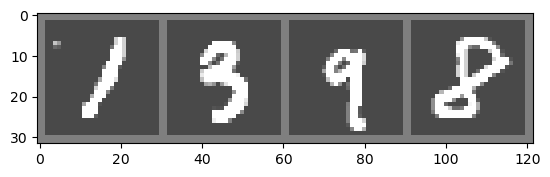

In [3]:
import matplotlib.pyplot as plt
from utils import imshow

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-300-100

LeNet-300-100 is a Fully-Connected neural network, presented in [[2](#2)].
It is composed by two hidden layers, with respectively 300 and 100 units.

Differently from the original implementation, we employ ReLU activation instead of tanh, and we use a softmax over the last layer logits to calculate the predictions and a negative log likelihood loss.

In [4]:
 # build model architecture
model = config.init_obj('arch', module_arch)
print(model)

# get function handles of loss and metrics
criterion = getattr(F, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# load pretrained model
print('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load(config.resume)
state_dict = checkpoint['state_dict']
print('Accuracy before compression: {:.3f}'.format(checkpoint['monitor_best']))
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
Loading checkpoint: runs\models\Mnist_LeNet300\0305_212840\model_best.pth ...
Accuracy before compression: 0.980


LeNet300(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

The error rate on the validation set is 2%, which is slightly worse than what declared in the paper and in the original article of LeCun et al. , 1998.

## Pruning

We have explored two ways of pruning:
- pruning a certain percentage of weights
- pruning all the weights under a threshold, given by the standard deviation of weight magnitude, multiplied by a quality constant $s$

$$ \text{threshold} = \sigma * s $$

In [ ]:
pruners = config['pruners']
for pruner in pruners:
    # get type of pruning to use
    prune_fn = getattr(module_prune, pruner['type'])
    iterations = 1 if not 'iterations' in pruner else pruner['iterations']
    for it in range(iterations):
        # prune model
        model = module_prune.prune_model(model, prune_fn, pruner['levels'], None)

        # build optimizer, learning rate scheduler
        trainable_params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
        lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

        # avoid model reinitialization inside trainer
        config.resume = None

        trainer = Trainer(model, criterion, metrics, optimizer,
                          config=config,
                          device=device,
                          data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

        _, acc1, acc5 = trainer._valid_epoch(-1).values()
        #print("Pruning iteration - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

        if pruner['finetune_weights']:
            trainer.train()

        _, acc1, acc5 = trainer._valid_epoch(-1).values()

        print("Pruning iteration {:d} | acc@1:{:.3f} | acc@5:{:.3f}".format(it, acc1, acc5))

Train Epoch: 1 [0/54000 (0%)] Loss: 0.596636
Train Epoch: 1 [1408/54000 (3%)] Loss: 0.295775
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.213053
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.178406
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.194138
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.127438
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.106738
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.094582
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.118692
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.160390
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.115068
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.061751
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.113058
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.087402
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.078094
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.099120
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.031079
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.105421
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.037626
Train Epoch: 1 [26752/54000 (50%)] Loss: 0.053326
Train Epoch: 1 

In [ ]:
from copy import deepcopy
from collections import OrderedDict
import numpy as np

iterations = 10
sensitivities = OrderedDict()

_s = np.linspace(0,1,10)

We can see that validation accuracy drops after pruning, but once the model is finetuned, we reach a slightly better accuracy than the unpruned model. This was also noted in the Deep Compression paper

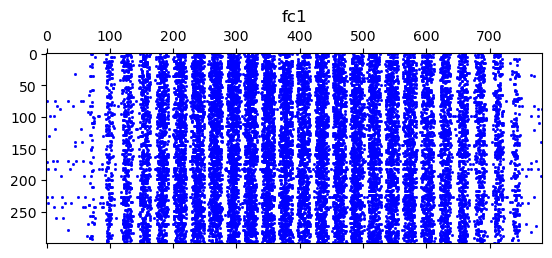

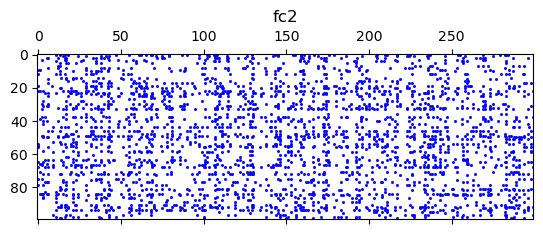

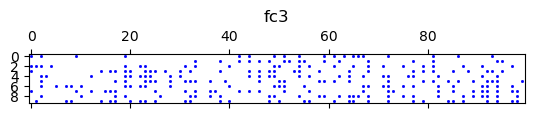

In [7]:
plot_sparsity_matrix(model)

We can see that the fc1 layer is divided in 28 vertical bands, whose width is 28, corresponding to the $28 \times 28$ input pixel.
As stated in [[2](#2)], network pruning detects visual attention regions: the colored regions, correspond to non-zero parameters, are more dense in the center of the image, since the digits are written in the center.

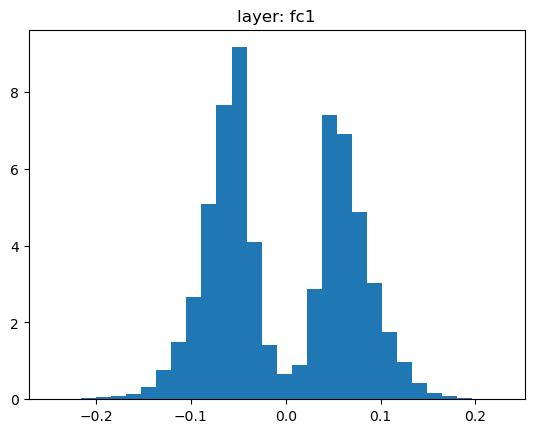

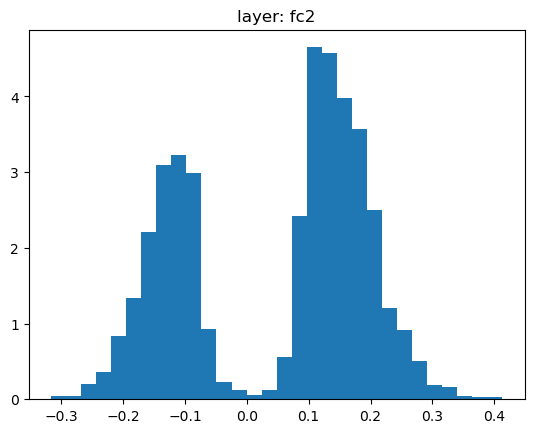

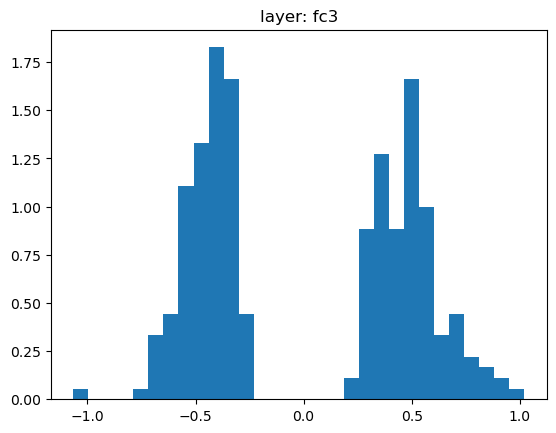

In [8]:
plot_weight_histograms(model)

Pruned weights follow a bimodal distribution

## Quantization

There are two ways of doing quantization:

- Reducing the number of bits used to represent each weight
- Create a codebook of weight values using a clustering algorithm, calculating the centroids of weight values and using only those centroids as the layer weights.

We have implemented the latter using three different quantization methods, which can be found inside `quantization.py`.
All the methods extend a common class `BaseQuantizationMethod` and differ by the way the space


In [10]:
quantizer = config['quantizer']
quantize_fn = getattr(module_quantize, quantizer['type'])

model = module_quantize.quantize_model(model, quantize_fn, quantizer['levels'], None)

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

trainer = Trainer(model, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after quantization - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

if quantizer['finetune_weights']:
    trainer.train()

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after finetuning - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

Tested model after quantization - acc@1:0.988 | acc@5:1.000
Train Epoch: 1 [0/54000 (0%)] Loss: 0.022457
Train Epoch: 1 [1408/54000 (3%)] Loss: 0.046887
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.014660
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.063586
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.006066
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.017466
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.042892
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.010601
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.007057
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.003818
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.003605
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.008371
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.008691
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.000953
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.003802
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.002054
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.006551
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.007084
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.001289
Train

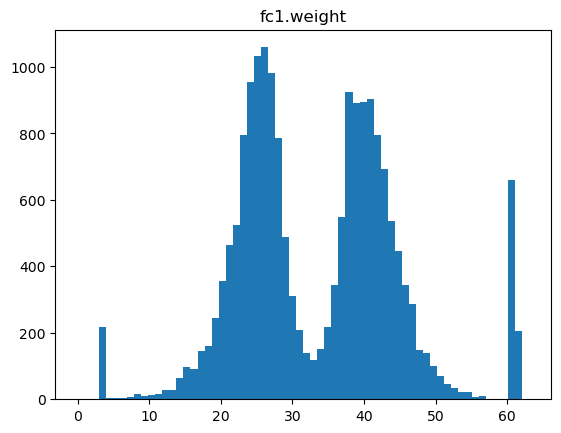

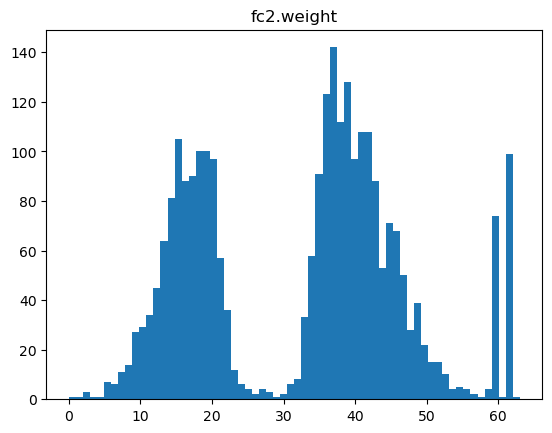

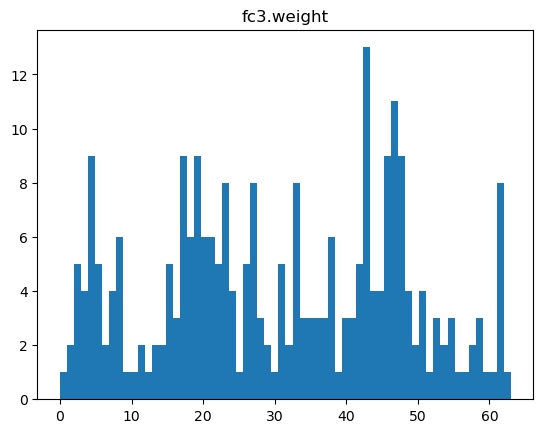

In [45]:
import numpy as np
for param_name, bits in quantizer['levels'].items():
    t = model.state_dict()[param_name + '_indices'].detach().cpu()
    plt.hist(t.numpy(),bins=2**bits)
    plt.title(param_name)
    plt.show()

## Huffman encoding

# LeNet-5

![Lenet5](./../assets/lenet-5_1.jpg "LeNet 5")

The input is a $32 \times 32$ image, since [[2](#2)] found desirable to have distinctive features of each character in the center of the receptive field of the highest-level feature detectors.

- C1 is a convolutional layer with 6 feature maps and a kernel of $5 \times 5$.
- S

Images need to be rescaled to size 32x32 as described in LeCun et al. 1998

## Learning connections

## Pruning

## Quantization

# References
<a id="1">[1]</a> Han, Song, Huizi Mao, and William J. Dally. "Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding." arXiv preprint arXiv:1510.00149 (2015).
<a id="1">[2]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[3]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).